## Import libraries

In [1]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

import sklearn
# evaluate RFE for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from xgboost import plot_importance



## Define reusable functions

#### Function for reading data from model dataset

In [2]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',')
    return df_data

## Read pre-processed multi-variable dataset

#### Set python variables

In [4]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data_v4.csv"

#### Read dataset into pandas dataframe

In [5]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [6]:
df_model_data

,year,month,date,temp_mean,temp_min,temp_max,temp_avg_daily_min,temp_avg_daily_max,degree_days,demand_mean,demand_max,demand_avg_daily_max,total_consumption,pv_capacity,population,gsp
0,2010,1,2010-01-01,20.868008,1.6,41.1,16.380645,25.858065,144.511358,8941.450389,13765.04,10613.530000,6554083.135,28278.392,7110454,44504.250000
1,2010,2,2010-02-01,20.218907,3.2,35.4,16.146429,24.682143,124.982743,8855.467677,13377.27,10380.667857,5831325.465,32153.986,7119405,44504.250000
2,2010,3,2010-03-01,19.828286,6.3,34.7,15.496774,24.725806,106.809763,8698.725127,11991.47,10132.978710,6319623.805,38195.588,7128356,44504.250000
3,2010,4,2010-04-01,17.593856,6.5,29.9,12.780000,23.063333,68.136038,8452.863411,11436.13,9804.072333,5984627.295,45142.723,7133668,44504.250000
4,2010,5,2010-05-01,15.323485,3.1,28.4,11.187097,19.596774,123.937772,8897.770510,12386.49,10558.023548,6459781.390,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,2021-08-01,21.104167,16.9,30.7,17.766667,24.966667,9.312500,7368.353056,9043.62,8410.176667,530521.420,3954209.744,8091356,57391.083333
140,2021,9,2021-09-01,20.999306,14.2,27.5,15.433333,25.300000,8.997917,7229.393819,9206.19,8469.680000,520516.355,4033918.477,8088503,57391.083333
141,2021,10,2021-10-01,21.084722,14.8,26.9,16.300000,25.466667,9.254167,7209.823194,8841.21,8575.093333,519107.270,4112353.036,8092743,57391.083333
142,2021,11,2021-11-01,22.118056,15.7,27.3,16.466667,26.566667,12.354167,7649.492569,9573.70,9336.970000,550763.465,4192992.282,8096983,57391.083333


## Using XGBoost Regressor feature importance

In [7]:
columns_to_drop = ['year', 'month', 'date', 'demand_mean', 'total_consumption', 'demand_avg_daily_max', 'demand_max']

## Split data into Response (y) and Independent (X) variable arrays

In [8]:
y_1 = df_model_data['demand_max']
y_2 = df_model_data['demand_mean']
y_3 = df_model_data['demand_avg_daily_max']

X = df_model_data.drop(columns=columns_to_drop, axis=1, inplace=False)

## Fit XGBoost Regression model and plot feature importance chart

In [9]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_1)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [10]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_1)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [11]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_1)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [12]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

In [13]:
df_result

,gain,cover,weight
temp_mean,0.010692,0.046841,0.277755
population,0.012885,0.200146,0.013109
temp_min,0.033421,0.088225,0.154445
temp_avg_daily_max,0.046970,0.119097,0.092995
temp_avg_daily_min,0.050697,0.095124,0.092585
gsp,0.095174,0.062615,0.002048
temp_max,0.173426,0.102823,0.134371
pv_capacity,0.198146,0.144938,0.138468
degree_days,0.378588,0.140191,0.094224


<Axes: title={'center': 'Feature importance - demand_max'}>

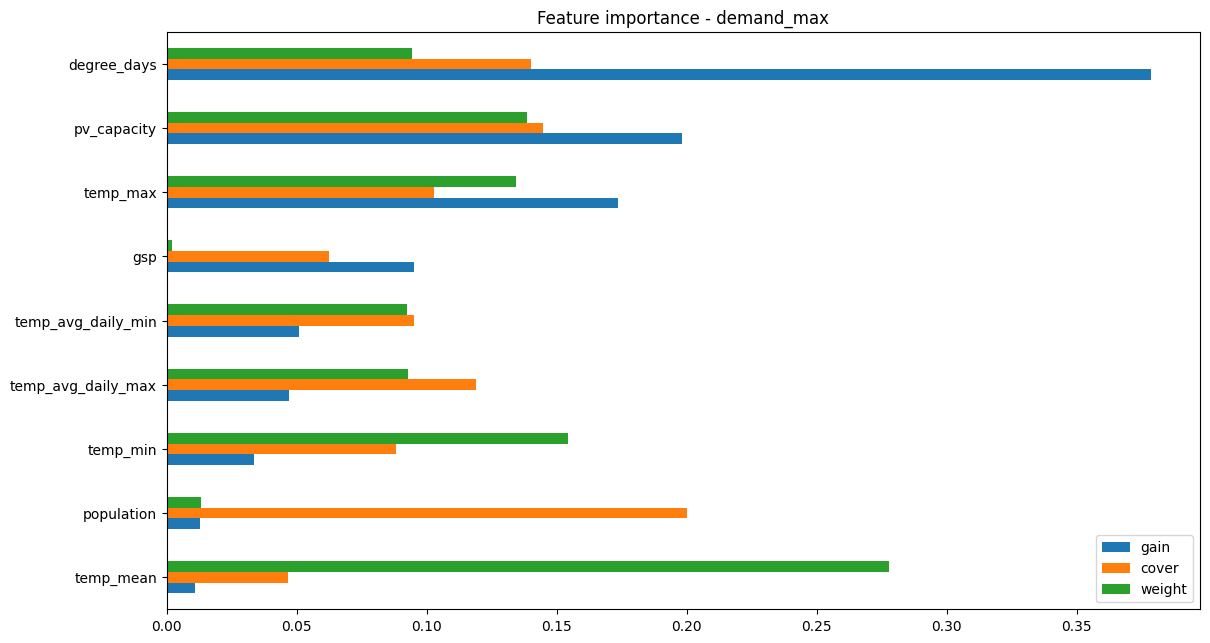

In [15]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_max')

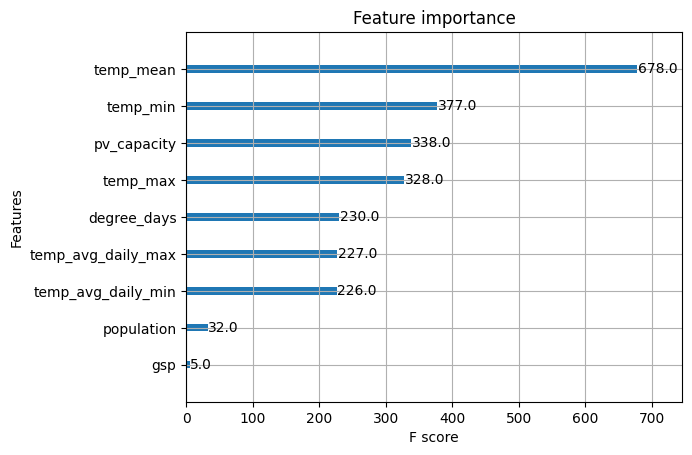

In [14]:
plot_importance(model)
plt.show()

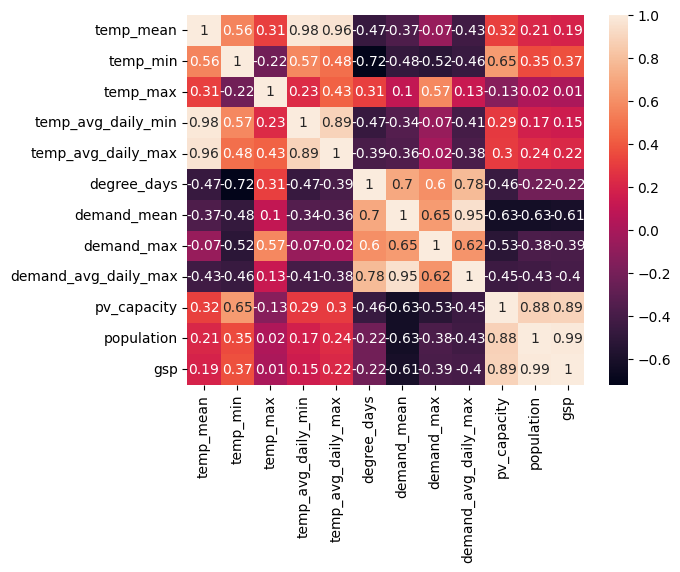

In [16]:
df_model_reduced = df_model_data.drop(['year', 'month', 'date', 'total_consumption'], axis=1, inplace=False)
matrix = df_model_reduced.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [17]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_2)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [18]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_2)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [19]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_2)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [20]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_mean'}>

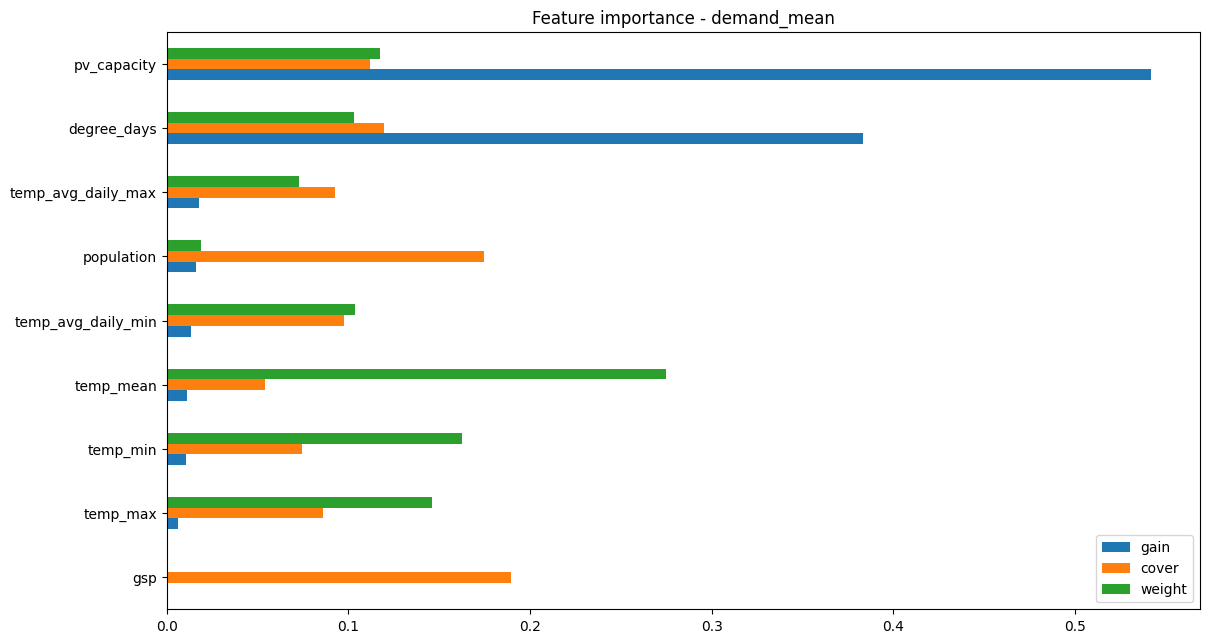

In [21]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_mean')

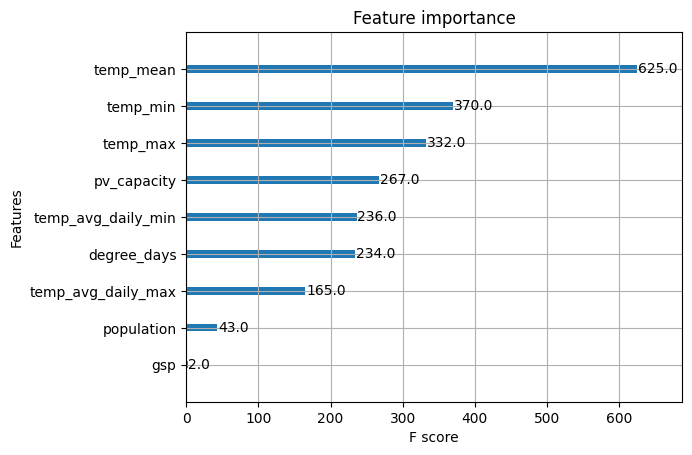

In [22]:
plot_importance(model)
plt.show()

In [23]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_3)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [24]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_3)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [25]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_3)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [26]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_avg_daily_max'}>

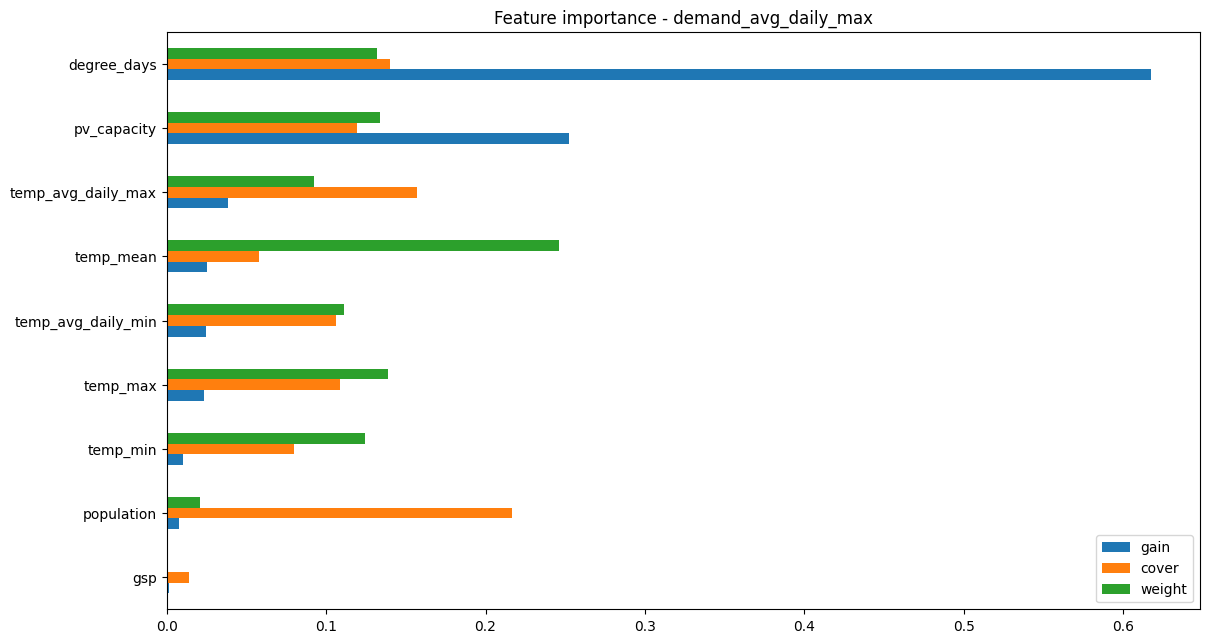

In [27]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_avg_daily_max')

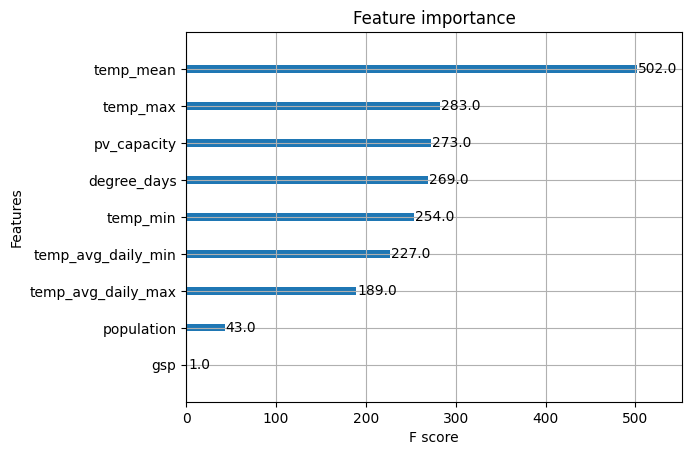

In [28]:
plot_importance(model)
plt.show()

## Using sklearn.feature_selection.RFE

In [29]:
# get a list of models to evaluate
def get_models():
 models = dict()
 # dt
 rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
 # gb
 rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['gb'] = Pipeline(steps=[('s',rfe),('m',model)])
 # rf
 rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
 
 return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [30]:
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y_3, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -245.301 (41.020)


>dt -250.237 (39.862)
>gb -236.452 (46.682)
>rf -242.610 (54.678)


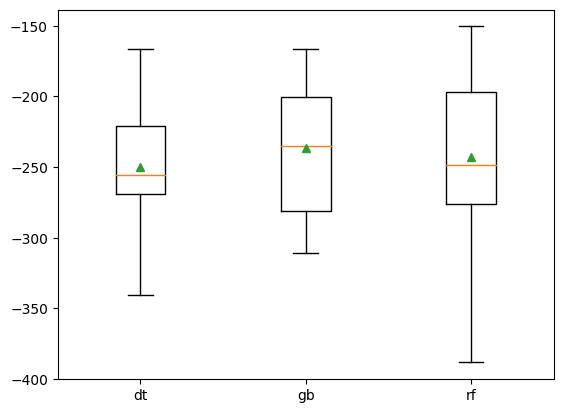

In [31]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 #print(name)
 scores = evaluate_model(model, X, y_3)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [32]:
scores

array([-240.282481  , -320.70131828, -212.93943974, -243.40918333,
       -273.46594684, -213.33070266, -274.60186022, -191.64741738,
       -290.88128994, -298.92569149, -166.78063251, -276.7913705 ,
       -388.27764019, -150.44360195, -164.36712179, -252.42379355,
       -155.8784255 , -283.84876273, -262.89505409, -302.47007053,
       -285.12003216, -269.41761315, -219.53508725, -222.29635832,
       -251.00597657, -182.01381896, -274.4816806 , -190.45314508,
       -245.89262696, -173.73046983])

In [33]:
X.columns

Index(['temp_mean', 'temp_min', 'temp_max', 'temp_avg_daily_min',
       'temp_avg_daily_max', 'degree_days', 'pv_capacity', 'population',
       'gsp'],
      dtype='object')

In [34]:
# report which features were selected by RFE

# define RFE
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
# fit RFE
rfe.fit(X, y_3)
# summarize all features
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 3.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected False, Rank: 5.000
Column: 3, Selected False, Rank: 2.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 6.000
